In [1]:
import pandas as pd
from pystac_client import Client 
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt
from dask.distributed import Client as dc # Import Dask Client
import numpy as np
import xarray as xr
import json
import uuid
import os
import ipyleaflet

from IPython.display import display_html, display_javascript

In [2]:
#load in the costco geojson
costco_example_gdf = gpd.read_file("../Data/costco_sample.geojson")
costco_example_gdf

,geometry
0,"POLYGON ((-93.43727 44.86198, -93.43727 44.858..."


In [3]:
# Create ipyleaflet Map
m = ipyleaflet.Map(center=(44.9, -93.2), zoom=15) # Default center, adjust as needed

# Convert GeoDataFrame to GeoJSON-like dictionary for ipyleaflet
costco_geojson = json.loads(gpd.GeoDataFrame(costco_example_gdf.geometry).to_json())

# Create ipyleaflet Map
m = ipyleaflet.Map(center=(costco_example_gdf.centroid[0].y, costco_example_gdf.centroid[0].x), zoom_control=True, scroll_wheel_zoom=True, zoom=15, layout={'height': '600px', 'width': '1600px'}) # Set width and height here) 

# Create GeoJSON layer
geojson_layer = ipyleaflet.GeoJSON(data=costco_geojson)

# Add the layer to the map
m.add_layer(geojson_layer)

# Display the map
m

C:\Users\wjeer\AppData\Local\Temp\ipykernel_20424\2250450149.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = ipyleaflet.Map(center=(costco_example_gdf.centroid[0].y, costco_example_gdf.centroid[0].x), zoom_control=True, scroll_wheel_zoom=True, zoom=15, layout={'height': '600px', 'width': '1600px'}) # Set width and height here)


Map(center=[44.86046959973128, -93.4359288035619], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [4]:
#Costco crs
costco_example_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
#connect to client
client = Client.open("https://earth-search.aws.element84.com/v1")

In [6]:
#create dates of interest
start_date = "2023-05-20"
end_date = "2023-06-04"

#search available scenes given the geometry
search = client.search(
    max_items=10,
    collections=['sentinel-2-l2a'],
    intersects = costco_example_gdf.geometry.values[0],
    datetime = start_date + "/" + end_date
)

#collect items
items = list(search.items())

print(f"{search.matched()} items found")

6 items found


In [7]:
#view what the scenes output looks like
list(search.items())

[<Item id=S2B_15TVK_20230603_0_L2A>,
 <Item id=S2B_15TVK_20230531_0_L2A>,
 <Item id=S2A_15TVK_20230529_0_L2A>,
 <Item id=S2A_15TVK_20230526_0_L2A>,
 <Item id=S2B_15TVK_20230524_0_L2A>,
 <Item id=S2B_15TVK_20230521_0_L2A>]

In [8]:
# this cell can be used in Jupyter Notebook. Use above if using JupyterLab
class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict) or isinstance(json_data, list):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html(
            '<div id="{}" style="height: 600px; width:100%;font: 12px/18px monospace '
            '!important;"></div>'.format(self.uuid),
            raw=True,
        )
        display_javascript(
            """
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"],
            function() {
                renderjson.set_show_to_level(2);
                document.getElementById('%s').appendChild(renderjson(%s))
        });
      """
            % (self.uuid, self.json_str),
            raw=True,
        )


RenderJSON(items[0].to_dict())

In [9]:
#how many cpus available
num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 8


In [10]:
#check out an item
items[0].to_dict()["assets"]['red']

{'href': 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/15/T/VK/2023/6/S2B_15TVK_20230603_0_L2A/B04.tif',
 'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
 'title': 'Red (band 4) - 10m',
 'eo:bands': [{'name': 'red',
   'common_name': 'red',
   'description': 'Red (band 4)',
   'center_wavelength': 0.665,
   'full_width_half_max': 0.038}],
 'gsd': 10,
 'proj:shape': [10980, 10980],
 'proj:transform': [10, 0, 399960, 0, -10, 5000040],
 'raster:bands': [{'nodata': 0,
   'data_type': 'uint16',
   'bits_per_sample': 15,
   'spatial_resolution': 10,
   'scale': 0.0001,
   'offset': -0.1}],
 'roles': ['data', 'reflectance']}


--- Processing Item: S2B_15TVK_20230603_0_L2A ---
Item Bounding Box: [-94.27253674079721, 44.15852444719924, -92.87584634429486, 45.15376076769412]


d:\Desktop\Projects\Costco-Run\.venv\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 114.98 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


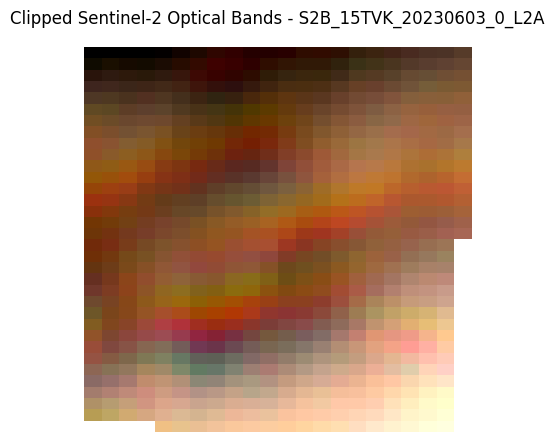


--- Processing Item: S2B_15TVK_20230531_0_L2A ---
Item Bounding Box: [-93.87943230012375, 44.16199050510408, -92.87584634429486, 45.15376076769412]


d:\Desktop\Projects\Costco-Run\.venv\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 114.98 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


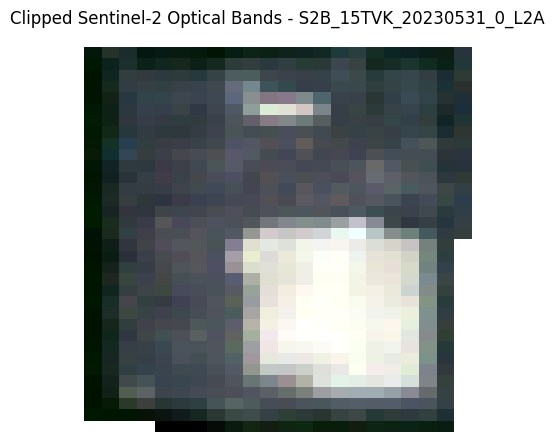


--- Processing Item: S2A_15TVK_20230529_0_L2A ---
Item Bounding Box: [-94.27253674079721, 44.15852444719924, -92.87584634429486, 45.15376076769412]


d:\Desktop\Projects\Costco-Run\.venv\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 114.98 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


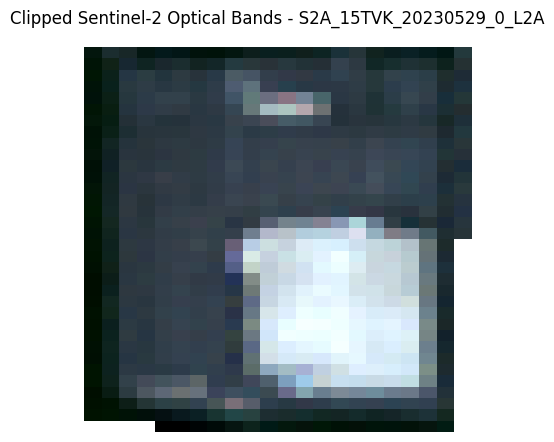


--- Processing Item: S2A_15TVK_20230526_0_L2A ---
Item Bounding Box: [-93.89043699142118, 44.16190525616861, -92.87584634429486, 45.15376076769412]


d:\Desktop\Projects\Costco-Run\.venv\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 114.98 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


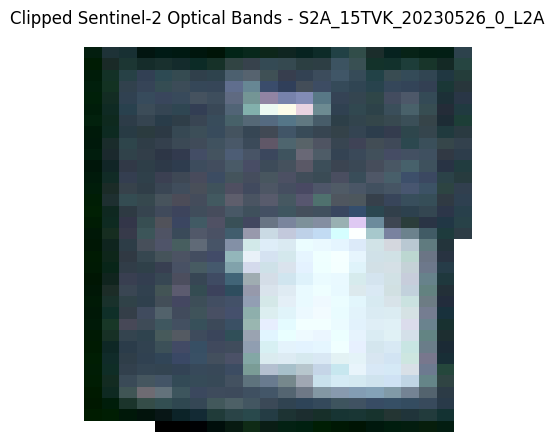


--- Processing Item: S2B_15TVK_20230524_0_L2A ---
Item Bounding Box: [-94.27253674079721, 44.15852444719924, -92.87584634429486, 45.15376076769412]


d:\Desktop\Projects\Costco-Run\.venv\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 114.98 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


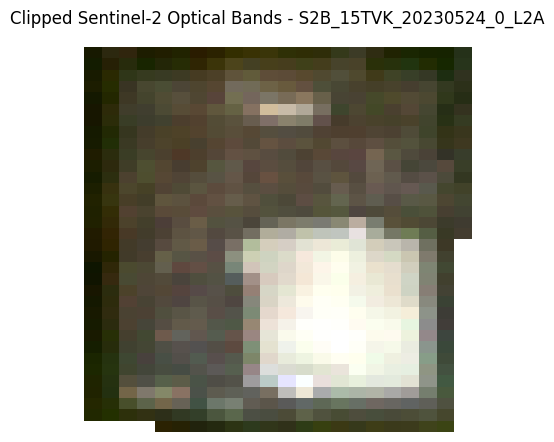


--- Processing Item: S2B_15TVK_20230521_0_L2A ---
Item Bounding Box: [-93.88731055204595, 44.16192958326645, -92.87584634429486, 45.15376076769412]


d:\Desktop\Projects\Costco-Run\.venv\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 114.98 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


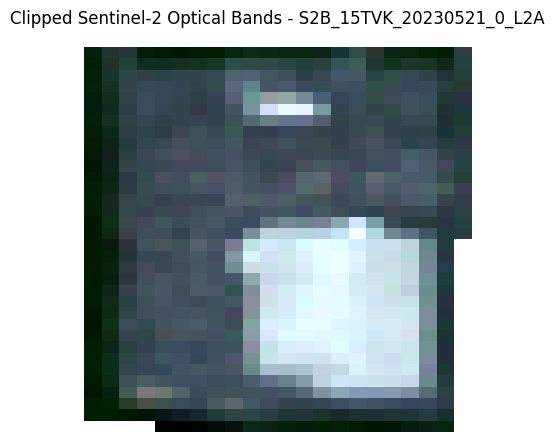

In [11]:
#set up dask client
dask_client = dc(n_workers=14, threads_per_worker=1)  # Or use a different port

band_names = ["red", "green", "blue"]  # Bands for optical visualization

for item in items:
    # ... (print statements before asset loop)
    print(f"\n--- Processing Item: {item.id} ---")
    print(f"Item Bounding Box: {item.bbox}")  # Print the item's bbox

    bands_data = []  # List to store DataArrays for each band

    for asset_name, asset in item.assets.items():
        if asset_name in band_names:  # Check if the asset is one of the bands we want
            try:
                # Open with rioxarray and Dask chunking
                da = rioxarray.open_rasterio(asset.href, masked=True, chunks=(1, 1024, 1024))
                #print(f"\n  -- Processing Asset: {asset_name} --")
                #print(f"  Raster CRS: {da.rio.crs}")  # Print raster CRS

                # Ensure CRS consistency
                #print(f"  gdf CRS (before potential to_crs): {costco_example_gdf.crs}")  # Print gdf CRS before check
                if costco_example_gdf.crs != da.rio.crs:
                    #print("  CRS mismatch detected, transforming gdf CRS...")
                    gdf = costco_example_gdf.to_crs(32615)
                else:
                    print("  CRS match, no transformation needed.")
                #print(f"  gdf CRS (after potential to_crs): {gdf.crs}")  # Print gdf CRS after check
                
                # Clip the Dask array
                clipped_da = da.rio.clip(gdf.geometry.values, drop=True)  # Clip here
                bands_data.append(clipped_da) # Append clipped band data

            except Exception as e:
                #print(f"Error processing asset {asset_name}: {e}")  # More specific message
                continue  # Continue to the next asset

    if bands_data: # Check if we have data for the bands
        try:
            # Stack bands and visualize as RGB
            rgb_da = xr.concat(bands_data, dim="band") # Concatenate along a new 'band' dimension

            plt.figure(figsize=(5, 5))
            rgb_da.compute().plot.imshow(rgb="band", robust=True) # Plot as RGB, robust=True for contrast
            plt.title(f"Clipped Sentinel-2 Optical Bands - {item.id}")
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error stacking and plotting bands: {e}")

    # break  # uncomment to visualize only the first item

dask_client.close()